In [1]:
import os
import cv2
from tqdm import tqdm

image_root = 'public_test'
de_detr = {}
yolo11 = {}
image_shapes = {}
print("loading image shapes")
for image_file in tqdm(os.listdir(image_root)):
    shape = cv2.imread(os.path.join(image_root, image_file)).shape[:2]
    image_shapes[image_file] = shape
    de_detr[image_file] = {
        "bboxes": [],
        "labels": [],
        "scores": []
    }
    yolo11[image_file] = {
        "bboxes": [],
        "labels": [],
        "scores": []
    }

loading image shapes


100%|██████████| 2060/2060 [02:23<00:00, 14.39it/s]


In [4]:
import cv2
import numpy as np
from ultralytics.utils.plotting import Annotator, colors
from PIL import Image

def cv2_to_pil(opencv_image):
    color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB) 
    pil_image = Image.fromarray(color_coverted) 
    
    return pil_image
def visualize_detection(image, boxes_list, labels, class_idx, font_size=1, line_width=1):
    height, width = image.shape[:2]
    boxes = [ [x1 * width, y1 * height, x2 * width, y2 * height] for (x1, y1, x2, y2) in boxes_list]
    boxes = np.array(boxes)
    # Initialize annotator
    annotator = Annotator(
        image.copy(),
        line_width=line_width,
        font_size=font_size,
        font="Arial.ttf",
        pil=False
    )

    # Draw each box
    for idx, (box, label) in enumerate(zip(boxes, labels)):
        x1, y1, x2, y2 = box
        bbox = [x1, y1, x2, y2]
        annotator.box_label(bbox, label, color=colors(class_idx[idx], bgr=True))
    return annotator.result()

In [12]:
for image_file in list(yolo11.keys()):
    yolo11[image_file] = {
        "bboxes": [],
        "labels": [],
        "scores": []
    }

yolo11_prediction_dir = "nov_17_yolov11l_conf15_lighting/labels"

for label_file in tqdm(os.listdir(yolo11_prediction_dir)):
    image_file = label_file[:-3] + 'jpg'
    with open(os.path.join(yolo11_prediction_dir, label_file), "r") as f:
        for line in f:
            cls, xc, yc, w, h, conf = line.split()
            cls = int(cls)
            xc = float(xc)
            yc = float(yc)
            w = float(w)
            h = float(h)
            score = float(conf)
            x1 = xc - w/2
            y1 = yc - h/2
            x2 = xc + w/2
            y2 = yc + h/2
            yolo11[image_file]["bboxes"].append([x1, y1, x2, y2])
            yolo11[image_file]["labels"].append(cls)
            yolo11[image_file]["scores"].append(score)

100%|██████████| 2060/2060 [00:25<00:00, 79.66it/s] 


In [13]:
for image_file in list(de_detr.keys()):
    de_detr[image_file] = {
        "bboxes": [],
        "labels": [],
        "scores": []
    }

de_detr_prediction_path = 'nov_17_dedetr_conf001_last13_lighting/predict.txt'

with open(de_detr_prediction_path, 'r') as f:
    for line in f:
        image_file, cls, x1, y1, x2, y2, conf = line.split(' ')
        height, width = image_shapes[image_file]
        cls = int(cls)
        x1 = float(x1) / width
        y1 = float(y1) / height
        x2 = float(x2) / width
        y2 = float(y2) / height
        conf = float(conf)
        
        de_detr[image_file]["bboxes"].append([x1, y1, x2, y2])
        de_detr[image_file]["labels"].append(cls)
        de_detr[image_file]["scores"].append(conf)

In [6]:
def calculate_iou_normalized_xyxy(box1, box2):
    """
    Calculate IoU between two normalized bounding boxes in xyxy format.
    
    Args:
        box1: numpy array of shape (N, 4) or (4,) in normalized xyxy format [x1, y1, x2, y2]
        box2: numpy array of shape (M, 4) or (4,) in normalized xyxy format [x1, y1, x2, y2]
        
    Returns:
        iou: numpy array of shape (N, M) containing the pairwise IoU values 
             if boxes are arrays, otherwise a single float
    """
    # Convert to numpy arrays if not already
    box1 = np.array(box1)
    box2 = np.array(box2)
    
    # Add dimension if single box
    if box1.ndim == 1:
        box1 = box1[None, :]
    if box2.ndim == 1:
        box2 = box2[None, :]
        
    # Get coordinates
    x1_1, y1_1, x2_1, y2_1 = np.split(box1, 4, axis=1)  # box1: (N,1)
    x1_2, y1_2, x2_2, y2_2 = np.split(box2, 4, axis=1)  # box2: (M,1)
    
    # Calculate intersection coordinates
    x1_i = np.maximum(x1_1, x1_2.T)  # (N,M)
    y1_i = np.maximum(y1_1, y1_2.T)
    x2_i = np.minimum(x2_1, x2_2.T)
    y2_i = np.minimum(y2_1, y2_2.T)
    
    # Calculate intersection area
    w_i = np.maximum(0, x2_i - x1_i)  # (N,M)
    h_i = np.maximum(0, y2_i - y1_i)
    intersection = w_i * h_i  # (N,M)
    
    # Calculate box areas
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)  # (N,1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)  # (M,1)
    
    # Calculate union area
    union = area1 + area2.T - intersection  # (N,M)
    
    # Calculate IoU
    iou = intersection / np.maximum(union, np.finfo(float).eps)  # avoid division by zero
    
    # Return single float if comparing individual boxes
    if iou.size == 1:
        return float(iou)
    
    return iou

import cv2
import numpy as np

def stack_images_horizontal(images, titles=None, scale=1.0, padding=20):
    """
    Stack images horizontally with titles above them.
    
    Parameters:
        images (list): List of images to stack
        titles (list): List of titles for each image (optional)
        scale (float): Scale factor for resizing images
        padding (int): Padding between images and for titles
        
    Returns:
        numpy.ndarray: Combined image with titles
    """
    if titles is None:
        titles = [f"Image {i+1}" for i in range(len(images))]
    
    if len(images) != len(titles):
        raise ValueError("Number of images and titles must match")
    
    # Resize images to the same height
    heights = [int(img.shape[0] * scale) for img in images]
    max_height = max(heights)
    
    # Add space for titles (using a black background)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8 * scale
    font_thickness = max(1, int(2 * scale))
    title_height = int(40 * scale)  # Height for title section
    
    # Calculate total width needed
    scaled_widths = [int(img.shape[1] * scale * (max_height / img.shape[0])) for img in images]
    total_width = sum(scaled_widths) + padding * (len(images) + 1)
    
    # Create blank canvas
    result = np.ones((max_height + title_height + padding * 2, total_width, 3), dtype=np.uint8) * 255
    
    # Current x position for placing images
    current_x = padding
    
    for img, title, scaled_width in zip(images, titles, scaled_widths):
        # Resize image maintaining aspect ratio
        height = int(img.shape[0] * scale)
        width = int(img.shape[1] * scale * (max_height / img.shape[0]))
        resized = cv2.resize(img, (width, height))
        
        # Convert grayscale to BGR if necessary
        if len(resized.shape) == 2:
            resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2BGR)
        
        # Place image
        y_offset = title_height + padding
        result[y_offset:y_offset + height, current_x:current_x + width] = resized
        
        # Add title
        title_size = cv2.getTextSize(title, font, font_scale, font_thickness)[0]
        title_x = current_x + (width - title_size[0]) // 2
        title_y = padding + title_height - padding
        cv2.putText(result, title, (title_x, title_y), font, font_scale, (0, 0, 0), font_thickness)
        
        current_x += width + padding
    
    return result

import cv2
import numpy as np

def stack_images_grid_2_1(images, titles=None, padding=20):
    """
    Stack three images in a 2x1 grid format where:
    - First row has 2 images side by side
    - Second row has 1 image stretched to full width while maintaining aspect ratio
    
    Parameters:
        images (list): List of 3 images to stack
        titles (list): List of titles for each image (optional)
        padding (int): Padding between images and for titles
        
    Returns:
        numpy.ndarray: Combined image with titles
    """
    if len(images) != 3:
        raise ValueError("Exactly 3 images are required")
        
    if titles is None:
        titles = [f"Image {i+1}" for i in range(3)]
    
    # Font settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    font_thickness = 2
    title_height = 40
    
    # Calculate dimensions for the first row images
    img1, img2, img3 = images
    
    # Get the maximum height for the first row
    row1_height = max(img1.shape[0], img2.shape[0])
    
    # Calculate the width for images in first row (equal widths)
    total_width = max(img1.shape[1] + img2.shape[1], img3.shape[1]) + padding * 3
    row1_width = (total_width - padding * 3) // 2
    
    # Calculate height for the bottom image maintaining aspect ratio
    bottom_width = total_width - padding * 2
    aspect_ratio = img3.shape[1] / img3.shape[0]
    bottom_height = int(bottom_width / aspect_ratio)
    
    # Create blank canvas
    total_height = row1_height + bottom_height + padding * 3 + title_height * 2
    result = np.ones((total_height, total_width, 3), dtype=np.uint8) * 255
    
    # Function to convert grayscale to BGR if needed
    def ensure_bgr(img):
        if len(img.shape) == 2:
            return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img
    
    # Process first row images
    # First image
    resized1 = cv2.resize(ensure_bgr(img1), (row1_width, row1_height))
    y_offset = title_height + padding
    result[y_offset:y_offset + row1_height, 
           padding:padding + row1_width] = resized1
    
    # Add title for first image
    title_size = cv2.getTextSize(titles[0], font, font_scale, font_thickness)[0]
    title_x = padding + (row1_width - title_size[0]) // 2
    cv2.putText(result, titles[0], 
                (title_x, padding + title_height - padding//2),
                font, font_scale, (0, 0, 0), font_thickness)
    
    # Second image
    resized2 = cv2.resize(ensure_bgr(img2), (row1_width, row1_height))
    result[y_offset:y_offset + row1_height,
           padding * 2 + row1_width:padding * 2 + row1_width * 2] = resized2
    
    # Add title for second image
    title_x = padding * 2 + row1_width + (row1_width - title_size[0]) // 2
    cv2.putText(result, titles[1],
                (title_x, padding + title_height - padding//2),
                font, font_scale, (0, 0, 0), font_thickness)
    
    # Process second row image (stretched while maintaining aspect ratio)
    resized3 = cv2.resize(ensure_bgr(img3), (bottom_width, bottom_height))
    y_offset = title_height + padding * 2 + row1_height + title_height
    result[y_offset:y_offset + bottom_height,
           padding:padding + bottom_width] = resized3
    
    # Add title for third image
    title_size = cv2.getTextSize(titles[2], font, font_scale, font_thickness)[0]
    title_x = padding + (bottom_width - title_size[0]) // 2
    cv2.putText(result, titles[2],
                (title_x, y_offset - padding//2),
                font, font_scale, (0, 0, 0), font_thickness)
    
    return result


src_1_frame_44_jpg.rf.fa175af33e4159aea5cfc1c06f488852.jpg


/home/viet/miniconda3/envs/goob/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


{0: 'motorbike', 1: 'automobile', 2: 'passenger car', 3: 'truck'}


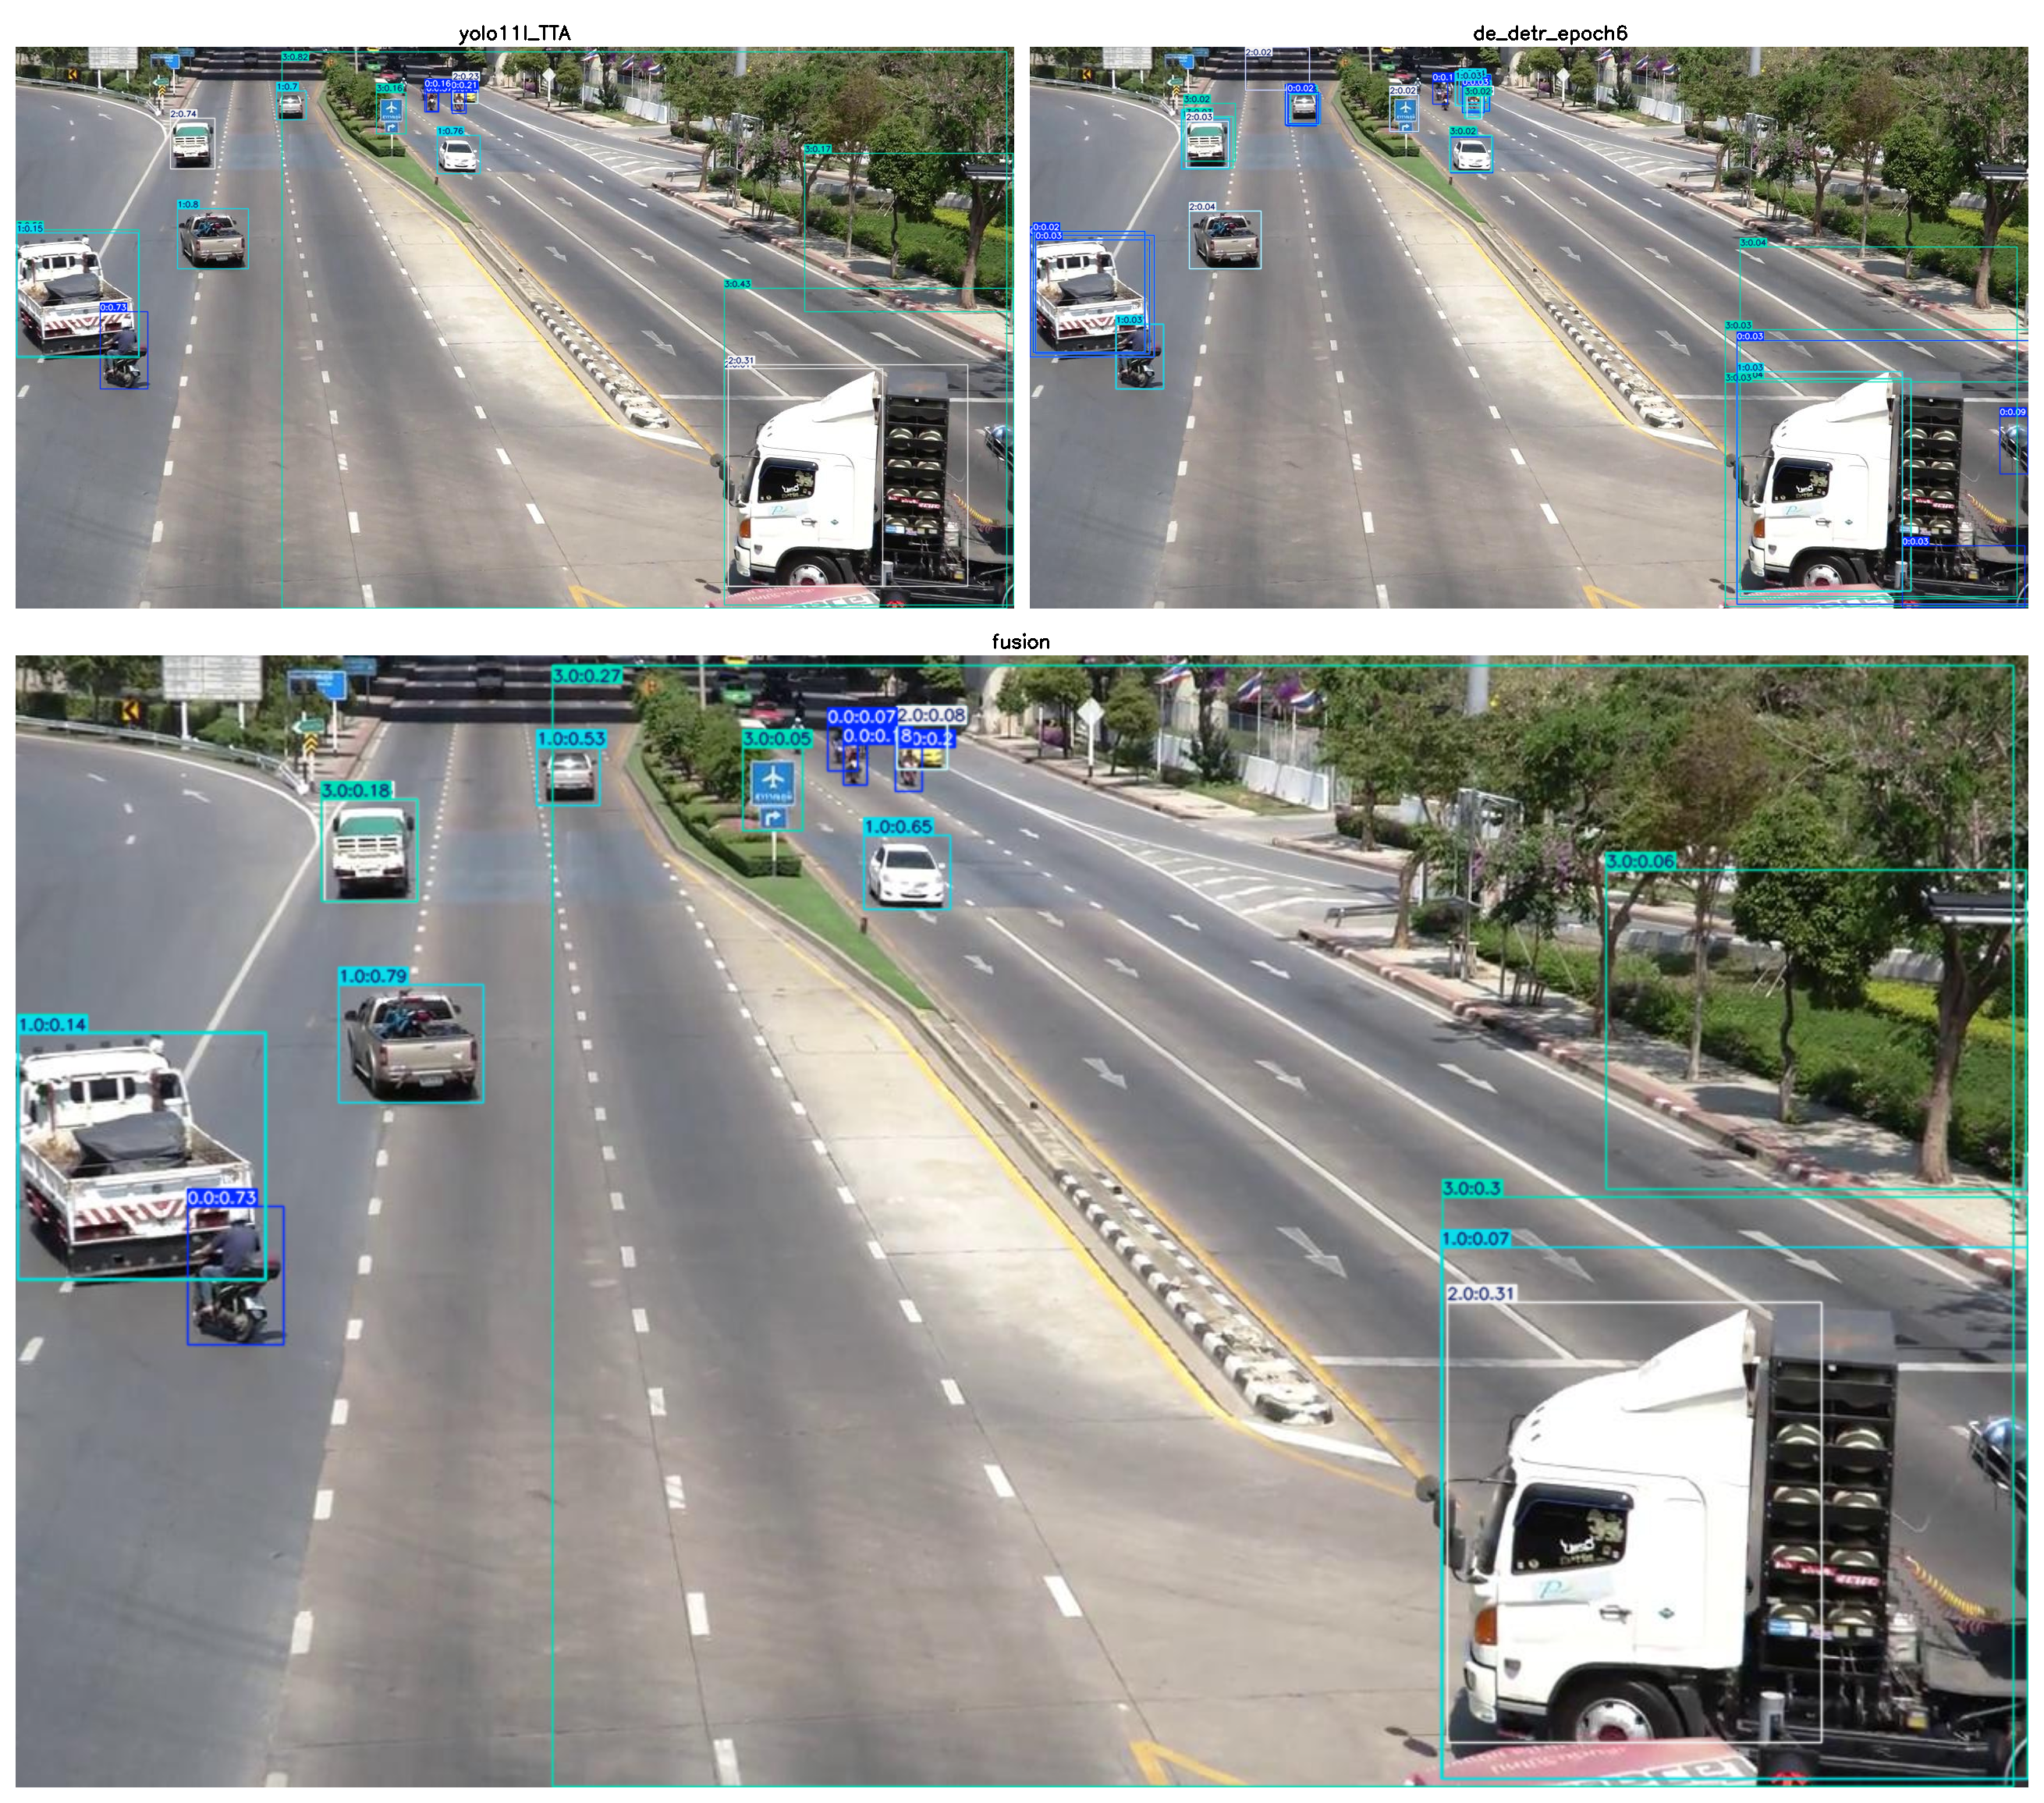

In [14]:
import random
from ensemble_boxes import *

id2label = {
    0:'motorbike', 
    1:'automobile', 
    2:'passenger car', 
    3:'truck'
}

def select_bbox(boxes, scores, labels):
    final_boxes, final_scores, final_labels = [], [], []
    flag = [True for box in boxes]
    for i, (box_i, score_i, label_i) in enumerate(zip(boxes, scores, labels)):
        if not flag[i]: continue
        for j, (box_j, score_j, label_j) in enumerate(zip(boxes, scores, labels)): 
            if not flag[j]: continue
            if j <= i: continue
            iou = calculate_iou_normalized_xyxy(box_i, box_j)
            if iou > 0.85:
                if score_i > score_j:
                    flag[j] = False
                else:
                    flag[i] = False
                    break

        if not flag[i]: continue
        final_boxes.append(box_i)
        final_scores.append(score_i)
        final_labels.append(label_i)

    return final_boxes, final_scores, final_labels

def magic_filter(boxes, scores, labels, area_threshold=0.065):
    final_boxes, final_scores, final_labels = [], [], []
    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        x1, y1, x2, y2 = box
        area = (x2 - x1) * (y2 - y1)
        if area > area_threshold: 
            continue
        final_boxes.append(box)
        final_scores.append(score)
        final_labels.append(label)

    return final_boxes, final_scores, final_labels


def detect(image_file):
    boxes_list = [
        yolo11[image_file]["bboxes"],
        de_detr[image_file]["bboxes"]
    ]
    labels_list = [
        yolo11[image_file]["labels"],
        de_detr[image_file]["labels"]
    ]
    scores_list = [
        yolo11[image_file]["scores"],
        de_detr[image_file]["scores"]
    ]
    weights = [
        1, 
        2
    ]
    iou_thr = 0.55
    skip_box_thr = 0.1
    # boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
    # boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, thresh=skip_box_thr)
    # boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, 
                                                  weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr,  conf_type="avg")

    # boxes, scores, labels = nms([boxes], [scores], [labels])
    # boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, 
    #                                               weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr,  conf_type="avg")
    # boxes, scores, labels = select_bbox(boxes, scores, labels)
    # boxes, scores, labels = magic_filter(boxes, scores, labels)
    return boxes, scores, labels


image_file = random.choice(list(yolo11.keys()))
print(image_file)
image = cv2.imread(os.path.join(image_root, image_file))

yolo11_boxes, yolo11_scores, yolo11_labels = yolo11[image_file]["bboxes"], yolo11[image_file]["scores"], yolo11[image_file]["labels"]
de_detr_boxes, de_detr_scores, de_detr_labels = de_detr[image_file]["bboxes"], de_detr[image_file]["scores"], de_detr[image_file]["labels"]
boxes, scores, labels = detect(image_file)

# viz_labels = [f"{id2label[label]}:{round(scores[i], 2)}" for i, label in enumerate(labels)]
viz_labels = [f"{label}:{round(scores[i], 2)}" for i, label in enumerate(labels)]
yolo11_viz_labels = [f"{label}:{round(yolo11_scores[i], 2)}" for i, label in enumerate(yolo11_labels)]
de_detr_viz_labels = [f"{label}:{round(de_detr_scores[i], 2)}" for i, label in enumerate(de_detr_labels)]

viz_image = visualize_detection(image, boxes, viz_labels, labels)
yolo11_image = visualize_detection(image, yolo11_boxes, yolo11_viz_labels, yolo11_labels)
de_detr_image = visualize_detection(image, de_detr_boxes, de_detr_viz_labels, de_detr_labels)

print(id2label)
cv2_to_pil(stack_images_grid_2_1([yolo11_image, de_detr_image, viz_image], ["yolo11l_TTA", "de_detr_epoch6", "fusion"]))

In [15]:
def xyxy_2_xywh(bbox):
    x1, y1, x2, y2 = bbox
    w = x2 - x1
    h = y2 - y1
    xc = x1 + w/2
    yc = y1 + h/2

    return [xc, yc, w, h]
    
with open("predict.txt", "w") as f:
    for image_file in tqdm(list(de_detr.keys())):
        boxes, scores, labels = detect(image_file)

        cvt_bboxes = [xyxy_2_xywh(box) for box in boxes]
        for bbox, score, label in zip (cvt_bboxes, scores, labels):
            xc, yc, w, h = bbox
            f.write(f'{image_file} {int(label)} {xc} {yc} {w} {h} {score}\n')

  0%|          | 0/2060 [00:00<?, ?it/s]/home/viet/miniconda3/envs/goob/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:42: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/home/viet/miniconda3/envs/goob/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
  1%|          | 19/2060 [00:00<01:02, 32.69it/s]/home/viet/miniconda3/envs/goob/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
100%|██████████| 2060/2060 [00:59<00:00, 34.87it/s] 


In [16]:
!zip nov_17_deyolighting_wbf_conf10_iou55_weights12_yoloTTA_dedetrlast13.zip predict.txt

  adding: predict.txt (deflated 66%)
